In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [ ]:
print(path)

/kaggle/input/chest-xray-pneumonia


In [ ]:
import os
path+="/chest_xray"
os.listdir(path)

['chest_xray', '__MACOSX', 'val', 'test', 'train']

In [ ]:
import os
import random
import hashlib
from PIL import Image

label_map = {"NORMAL": 0, "PNEUMONIA": 1}
all_data = []
seen_hashes = set()

def calculate_hash(img_path):
    try:
        with Image.open(img_path) as img:
            img = img.convert('RGB')  # ensure consistent mode
            return hashlib.md5(img.tobytes()).hexdigest()
    except Exception as e:
        print(f"Error hashing {img_path}: {e}")
        return None

# Combine all images from train, val, test folders
for split in ["train", "val", "test"]:
    split_path = os.path.join(path, split)
    for label_folder in os.listdir(split_path):
        label_folder_clean = label_folder.strip().upper()
        if label_folder_clean not in label_map:
            print(f"Skipping unknown label folder: {label_folder}")
            continue
        label = label_map[label_folder_clean]
        full_folder_path = os.path.join(split_path, label_folder)
        for img in os.listdir(full_folder_path):
            if img.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(full_folder_path, img)
                img_hash = calculate_hash(img_path)
                if img_hash and img_hash not in seen_hashes:
                    all_data.append([img_path, label])
                    seen_hashes.add(img_hash)
                else:
                    print(f"Duplicate removed: {img_path}")

# Shuffle all data
random.shuffle(all_data)

# 70-20-10 split
total = len(all_data)
train_size = int(0.7 * total)
val_size = int(0.2 * total)

train = all_data[:train_size]
val = all_data[train_size:train_size + val_size]
test = all_data[train_size + val_size:]

print("Total unique images:", total)
print("Train:", len(train))
print("Validation:", len(val))
print("Test:", len(test))


Duplicate removed: /kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person30_bacteria_157.jpeg
Duplicate removed: /kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1430_bacteria_3695.jpeg
Duplicate removed: /kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person834_bacteria_2748.jpeg
Duplicate removed: /kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1159_virus_1945.jpeg
Duplicate removed: /kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1619_bacteria_4268.jpeg
Duplicate removed: /kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person258_bacteria_1209.jpeg
Duplicate removed: /kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person357_virus_735.jpeg
Duplicate removed: /kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person124_virus_246.jpeg
Duplicate removed: /kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1496_bacteria_3910.jpeg
Duplicate removed: 

In [ ]:
import pandas as pd
import numpy as np
import cv2

train_data=pd.DataFrame(train,columns=["img_path","label"])
test_data=pd.DataFrame(test,columns=["img_path","label"])
val_data=pd.DataFrame(val,columns=["img_path","label"])

array([[<Axes: title={'center': 'label'}>]], dtype=object)

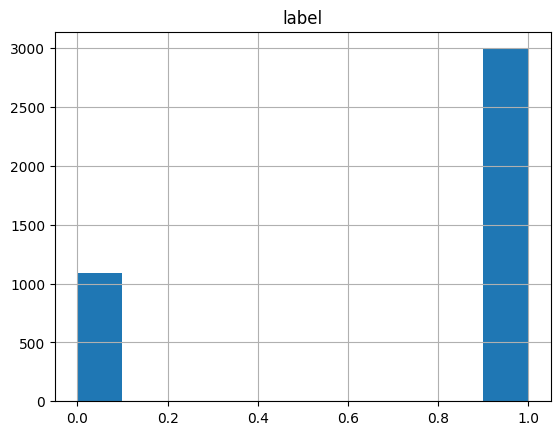

In [ ]:
#class Imbalance
train_data.hist()

In [ ]:
import tensorflow
import tensorflow.keras
from tensorflow.keras.applications import resnet50,MobileNetV2
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import AdamW,Adam,RMSprop

In [ ]:

# Convert labels to strings
train_data['label'] = train_data['label'].astype(str)
test_data['label'] = test_data['label'].astype(str)
val_data['label'] = val_data['label'].astype(str)


train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.5, 1.5],
)

# Rescale only for validation and testing
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)


# Flow from DataFrames (avoid overwriting)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col="img_path",
    y_col="label",
    target_size=(224, 224),
    batch_size=45,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col="img_path",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'  # add this
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col="img_path",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'  # add this
)

Found 4076 validated image filenames belonging to 2 classes.
Found 584 validated image filenames belonging to 2 classes.
Found 1164 validated image filenames belonging to 2 classes.


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data['label']),
    y=train_data['label']
)

class_weights = dict(zip(np.unique(train_data['label']), class_weights_array))

print("Class Weights:", class_weights)


Class Weights: {'0': np.float64(1.8766114180478821), '1': np.float64(0.6816053511705685)}


In [ ]:
base_model=MobileNetV2(include_top=False,weights='imagenet',input_shape=(224,224,3))
base_model.trainable=False

In [ ]:
reg=L1L2(l1=7e-8,l2=1e-5)

In [ ]:
for layer in base_model.layers[-4:]:
    layer.trainable=True

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=BatchNormalization()(x)
x=Dropout(0.45)(x)
x=Dense(512,activation='relu',kernel_regularizer=reg,bias_regularizer=reg)(x)

predictions=Dense(1,activation='sigmoid')(x)

model=Model(inputs=base_model.input,outputs=predictions)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,919,489 (11.14 MB)

 Trainable params: 1,071,745 (4.09 MB)

 Non-trainable params: 1,847,744 (7.05 MB)

In [ ]:
for layer in model.layers:
    print(layer, layer.trainable)

<InputLayer name=input_layer, built=True> False
<Conv2D name=Conv1, built=True> False
<BatchNormalization name=bn_Conv1, built=True> False
<ReLU name=Conv1_relu, built=True> False
<DepthwiseConv2D name=expanded_conv_depthwise, built=True> False
<BatchNormalization name=expanded_conv_depthwise_BN, built=True> False
<ReLU name=expanded_conv_depthwise_relu, built=True> False
<Conv2D name=expanded_conv_project, built=True> False
<BatchNormalization name=expanded_conv_project_BN, built=True> False
<Conv2D name=block_1_expand, built=True> False
<BatchNormalization name=block_1_expand_BN, built=True> False
<ReLU name=block_1_expand_relu, built=True> False
<ZeroPadding2D name=block_1_pad, built=True> False
<DepthwiseConv2D name=block_1_depthwise, built=True> False
<BatchNormalization name=block_1_depthwise_BN, built=True> False
<ReLU name=block_1_depthwise_relu, built=True> False
<Conv2D name=block_1_project, built=True> False
<BatchNormalization name=block_1_project_BN, built=True> False
<Con

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
callbacks=[EarlyStopping(monitor='val_loss',patience=4,verbose=1),
           ModelCheckpoint(filepath='best_model_pneumonia.keras',monitor='val_accuracy',save_best_only=True,verbose=1),
           ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.7,
                                 patience=1,
                                 verbose=1,
                                 min_lr=8e-7)]

In [ ]:
model.compile(optimizer=AdamW(learning_rate=1e-5),loss='binary_crossentropy',metrics=['accuracy','auc'])

In [ ]:
history=model.fit(train_generator,epochs=30,validation_data=val_generator,callbacks=callbacks, class_weight=class_weights)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 985ms/step - accuracy: 0.5437 - auc: 0.6100 - loss: 0.9171
Epoch 1: val_accuracy improved from -inf to 0.30069, saving model to best_model_pneumonia.keras
91/91 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.5441 - auc: 0.6107 - loss: 0.9161 - val_accuracy: 0.3007 - val_auc: 0.7225 - val_loss: 1.2634 - learning_rate: 1.0000e-05
Epoch 2/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - accuracy: 0.6790 - auc: 0.8216 - loss: 0.6277
Epoch 2: val_accuracy improved from 0.30069 to 0.39948, saving model to best_model_pneumonia.keras
91/91 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.6793 - auc: 0.8218 - loss: 0.6274 - val_accuracy: 0.3995 - val_auc: 0.8404 - val_loss: 1.1084 - learning_rate: 1.0000e-05
Epoch 3/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 931ms/step - accuracy: 0.7548 - auc: 0.8713 - loss: 0.5259
Epoch 3: val_accuracy improved from 0.39948 to 0.51203, saving model to best_model_pneumonia.keras
91/91 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.7

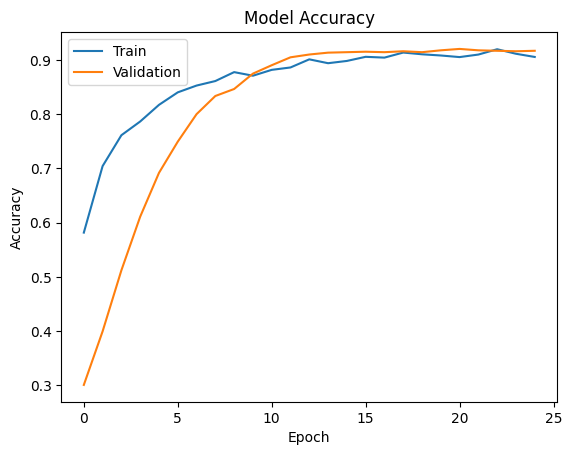

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

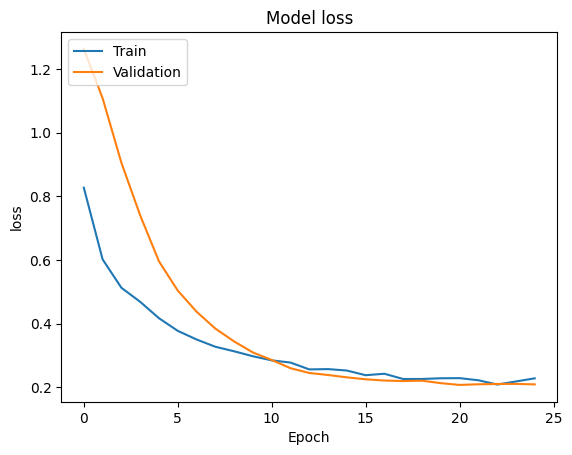

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Get true labels
true_labels = test_generator.classes  # From ImageDataGenerator

# 2. Get model predictions (probabilities)
pred_probs = model.predict(test_generator)
pred_labels = (pred_probs > 0.5).astype(int).reshape(-1)  # Convert to 0/1

# 3. Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
print("Confusion Matrix:\n", cm)

# Optional: Plot nicely
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 4. Precision, Recall, F1
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# 5. Full classification report
print("\nClassification Report:\n", classification_report(true_labels, pred_labels, target_names=["NORMAL", "PNEUMONIA"]))
